In [1]:
import torch 
import numpy as np
import pickle
from torch import nn, optim
from torch.nn import functional as F
import data_utils
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import seed
import utils

In [2]:
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)

In [3]:
# dataset path
data_path = "./data/var_u.mat" # Orig IB data

# Run on GPU if possible
#cuda = torch.cuda.is_available() 
#device = torch.device("cuda" if cuda else "cpu")
#print("Using "+ str(device))

In [4]:
def tensor_casting(dataset):
    return torch.tensor(dataset.X, dtype=torch.float32), \
           torch.tensor(dataset.y, dtype=torch.float32), \
           torch.tensor(dataset.c, dtype=torch.long)

In [5]:
trn, tst = utils.get_ib_data()

x_train, y_train, c_train = tensor_casting(trn)
x_test, y_test, c_test = tensor_casting(tst)

data = dict()
data['train'] = {}
data['train']['samples'] = x_train
data['train']['labels'] = y_train
data['train']['class'] = c_train
data['test'] = {}
data['test']['samples'] = x_test
data['test']['labels'] = y_test
data['test']['class'] = c_test

Loading Data...


In [6]:
config = {
    "loss_function" : nn.BCEWithLogitsLoss(),
    "batch_size" : 256,
    "epochs" : 5000,
    "layer_sizes" : [12,10,7,5,4,3,2]
}

In [7]:
# Load the data
#X_train, X_test, y_train, y_test = data_utils.load_data(data_path)

# Prepare data for pytorch
train_loader = data_utils.create_dataloader(x_train, y_train, len(x_train))
test_loader = data_utils.create_dataloader(x_test, y_test, len(x_test))

full_X, full_y = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
eval_loader = data_utils.create_dataloader(x_train, y_train, len(x_train))

In [8]:
# What do collect during training.
# Gradients of weights for all layers: something like ib_model.h3.weight.grad
# Weights for each layer: ib_model.h3.weight
# Activity: Save it in the forward pass and keep track of batch things.

# Compute L2 norm of weights
# Mean of gradients
# Std of gradients 
# Activity <- needed for MI 

In [9]:
class IBNet(nn.Module):
    def __init__(self, cfg):
        super(IBNet, self).__init__()
        torch.manual_seed(1234)
        # See https://pytorch.org/docs/stable/nn.html
        self.linears = nn.ModuleList()
        
        self.num_layers = len(cfg["layer_sizes"])
        self.inp_size = cfg["layer_sizes"][0]
        
        h_in = self.inp_size
        for h_out in cfg["layer_sizes"][1:]:
            self.linears.append(nn.Linear(h_in, h_out))
            h_in = h_out
    
        
    def forward(self, x):
        activations = [] #TODO: Could be nicer
        for idx in range(self.num_layers-1):
            x = torch.tanh(self.linears[idx](x))
            if idx == self.num_layers-1:
                x = self.linears[-1](x)
            if not self.training: #Internal flag in model
                activations.append(x)
         
        return x, activations

In [10]:
ib_model = IBNet(config)
optimizer = optim.Adam(ib_model.parameters(), lr=0.0004)

In [11]:
class Trainer:
    def __init__(self, cfg, model, optimizer):
        self.opt = optimizer
        self.loss_function = torch.nn.BCEWithLogitsLoss()
        self.batch_size = cfg["batch_size"]
        self.epochs = cfg["epochs"]
        self.model = model
        self.hidden_activations = [] # index 1: epoch num, index2 : layer_num
        self.weights = dict()
        self.ws_grads = dict()
        
        
    def _get_epoch_activity(self, eval_loader, val=False):
        """
        After each epoch save the activation of each hidden layer
        """
        self.model.eval()
        eval_loss = 0
        with torch.no_grad(): # Speeds up very little by turning autograd engine off.
            for i, (data, label) in enumerate(eval_loader):# No need to loop.
                data, label= data.to(device), label.to(device)
                yhat, activations = self.model(data)
                eval_loss += nn.BCEWithLogitsLoss()(yhat, label).item()
                
        if val:
            print('Validation loss: {:.7f}'.format(eval_loss))
        else:
            print('Evaluation loss: {:.7f}'.format(eval_loss))
        #print(activations)
        return list(map(lambda x:x.cpu().numpy(), activations))
    
    
    def train(self, samples, labels, classes):
        optimizer = optim.Adam(self.model.parameters(), lr=0.0004)
        criterion = nn.BCEWithLogitsLoss()
        for epoch in range(1, self.epochs+1):
            ### START MAIN TRAIN LOOP ###
            self.model.train()
            train_loss = 0
            
            self.opt.zero_grad()
            yhat, _ = self.model(samples)
            loss = criterion(yhat, labels)

            loss.backward()
            optimizer.step()
              
            #print(train_loss)
            #acc = (torch.tensor(list(map(torch.argmax, label.cpu()))) == yhat.cpu().argmax(dim=1)).sum() / float(len(label))
            #print("Accuracy :", acc)
            print('Epoch: {} Train loss: {:.7f}'.format(epoch, loss.item()))
            ### STOP MAIN TRAIN LOOP ###
                
            ### RUN ON VALIDATION DATA ###
            #self._get_epoch_activity(test_loader, val=True)
            
            ### SAVE ACTIVATION ON FULL DATA ###
            #self.hidden_activations.append(self._get_epoch_activity(eval_loader))


In [12]:
tr = Trainer(config, ib_model, optimizer)
tr.train(x_train, y_train, c_train)

Epoch: 1 Train loss: 0.6978789
Epoch: 2 Train loss: 0.6978106
Epoch: 3 Train loss: 0.6977426
Epoch: 4 Train loss: 0.6976743
Epoch: 5 Train loss: 0.6976055
Epoch: 6 Train loss: 0.6975372
Epoch: 7 Train loss: 0.6974685
Epoch: 8 Train loss: 0.6973994
Epoch: 9 Train loss: 0.6973305
Epoch: 10 Train loss: 0.6972612
Epoch: 11 Train loss: 0.6971919
Epoch: 12 Train loss: 0.6971222
Epoch: 13 Train loss: 0.6970519
Epoch: 14 Train loss: 0.6969820
Epoch: 15 Train loss: 0.6969118
Epoch: 16 Train loss: 0.6968409
Epoch: 17 Train loss: 0.6967704
Epoch: 18 Train loss: 0.6966990
Epoch: 19 Train loss: 0.6966274
Epoch: 20 Train loss: 0.6965557
Epoch: 21 Train loss: 0.6964837
Epoch: 22 Train loss: 0.6964113
Epoch: 23 Train loss: 0.6963385
Epoch: 24 Train loss: 0.6962656
Epoch: 25 Train loss: 0.6961919
Epoch: 26 Train loss: 0.6961178
Epoch: 27 Train loss: 0.6960434
Epoch: 28 Train loss: 0.6959683
Epoch: 29 Train loss: 0.6958929
Epoch: 30 Train loss: 0.6958172
Epoch: 31 Train loss: 0.6957406
Epoch: 32 Train l

Epoch: 305 Train loss: 0.5340458
Epoch: 306 Train loss: 0.5332404
Epoch: 307 Train loss: 0.5324423
Epoch: 308 Train loss: 0.5316517
Epoch: 309 Train loss: 0.5308682
Epoch: 310 Train loss: 0.5300921
Epoch: 311 Train loss: 0.5293232
Epoch: 312 Train loss: 0.5285612
Epoch: 313 Train loss: 0.5278066
Epoch: 314 Train loss: 0.5270591
Epoch: 315 Train loss: 0.5263185
Epoch: 316 Train loss: 0.5255851
Epoch: 317 Train loss: 0.5248585
Epoch: 318 Train loss: 0.5241389
Epoch: 319 Train loss: 0.5234261
Epoch: 320 Train loss: 0.5227204
Epoch: 321 Train loss: 0.5220211
Epoch: 322 Train loss: 0.5213289
Epoch: 323 Train loss: 0.5206432
Epoch: 324 Train loss: 0.5199643
Epoch: 325 Train loss: 0.5192918
Epoch: 326 Train loss: 0.5186259
Epoch: 327 Train loss: 0.5179665
Epoch: 328 Train loss: 0.5173136
Epoch: 329 Train loss: 0.5166669
Epoch: 330 Train loss: 0.5160267
Epoch: 331 Train loss: 0.5153925
Epoch: 332 Train loss: 0.5147647
Epoch: 333 Train loss: 0.5141432
Epoch: 334 Train loss: 0.5135274
Epoch: 335

Epoch: 600 Train loss: 0.4388267
Epoch: 601 Train loss: 0.4386624
Epoch: 602 Train loss: 0.4384985
Epoch: 603 Train loss: 0.4383345
Epoch: 604 Train loss: 0.4381710
Epoch: 605 Train loss: 0.4380077
Epoch: 606 Train loss: 0.4378448
Epoch: 607 Train loss: 0.4376822
Epoch: 608 Train loss: 0.4375194
Epoch: 609 Train loss: 0.4373573
Epoch: 610 Train loss: 0.4371952
Epoch: 611 Train loss: 0.4370336
Epoch: 612 Train loss: 0.4368722
Epoch: 613 Train loss: 0.4367107
Epoch: 614 Train loss: 0.4365498
Epoch: 615 Train loss: 0.4363891
Epoch: 616 Train loss: 0.4362285
Epoch: 617 Train loss: 0.4360682
Epoch: 618 Train loss: 0.4359083
Epoch: 619 Train loss: 0.4357482
Epoch: 620 Train loss: 0.4355887
Epoch: 621 Train loss: 0.4354293
Epoch: 622 Train loss: 0.4352700
Epoch: 623 Train loss: 0.4351112
Epoch: 624 Train loss: 0.4349523
Epoch: 625 Train loss: 0.4347938
Epoch: 626 Train loss: 0.4346355
Epoch: 627 Train loss: 0.4344774
Epoch: 628 Train loss: 0.4343195
Epoch: 629 Train loss: 0.4341618
Epoch: 630

Epoch: 878 Train loss: 0.3936634
Epoch: 879 Train loss: 0.3934753
Epoch: 880 Train loss: 0.3932876
Epoch: 881 Train loss: 0.3931006
Epoch: 882 Train loss: 0.3929142
Epoch: 883 Train loss: 0.3927284
Epoch: 884 Train loss: 0.3925434
Epoch: 885 Train loss: 0.3923592
Epoch: 886 Train loss: 0.3921756
Epoch: 887 Train loss: 0.3919928
Epoch: 888 Train loss: 0.3918109
Epoch: 889 Train loss: 0.3916296
Epoch: 890 Train loss: 0.3914493
Epoch: 891 Train loss: 0.3912698
Epoch: 892 Train loss: 0.3910912
Epoch: 893 Train loss: 0.3909133
Epoch: 894 Train loss: 0.3907363
Epoch: 895 Train loss: 0.3905604
Epoch: 896 Train loss: 0.3903854
Epoch: 897 Train loss: 0.3902110
Epoch: 898 Train loss: 0.3900377
Epoch: 899 Train loss: 0.3898651
Epoch: 900 Train loss: 0.3896936
Epoch: 901 Train loss: 0.3895231
Epoch: 902 Train loss: 0.3893533
Epoch: 903 Train loss: 0.3891847
Epoch: 904 Train loss: 0.3890167
Epoch: 905 Train loss: 0.3888499
Epoch: 906 Train loss: 0.3886836
Epoch: 907 Train loss: 0.3885187
Epoch: 908

Epoch: 1160 Train loss: 0.3585020
Epoch: 1161 Train loss: 0.3584325
Epoch: 1162 Train loss: 0.3583633
Epoch: 1163 Train loss: 0.3582944
Epoch: 1164 Train loss: 0.3582257
Epoch: 1165 Train loss: 0.3581573
Epoch: 1166 Train loss: 0.3580891
Epoch: 1167 Train loss: 0.3580211
Epoch: 1168 Train loss: 0.3579534
Epoch: 1169 Train loss: 0.3578857
Epoch: 1170 Train loss: 0.3578186
Epoch: 1171 Train loss: 0.3577516
Epoch: 1172 Train loss: 0.3576849
Epoch: 1173 Train loss: 0.3576184
Epoch: 1174 Train loss: 0.3575522
Epoch: 1175 Train loss: 0.3574862
Epoch: 1176 Train loss: 0.3574204
Epoch: 1177 Train loss: 0.3573549
Epoch: 1178 Train loss: 0.3572897
Epoch: 1179 Train loss: 0.3572246
Epoch: 1180 Train loss: 0.3571597
Epoch: 1181 Train loss: 0.3570951
Epoch: 1182 Train loss: 0.3570306
Epoch: 1183 Train loss: 0.3569664
Epoch: 1184 Train loss: 0.3569024
Epoch: 1185 Train loss: 0.3568386
Epoch: 1186 Train loss: 0.3567751
Epoch: 1187 Train loss: 0.3567118
Epoch: 1188 Train loss: 0.3566487
Epoch: 1189 Tr

Epoch: 1457 Train loss: 0.3424232
Epoch: 1458 Train loss: 0.3423873
Epoch: 1459 Train loss: 0.3423512
Epoch: 1460 Train loss: 0.3423151
Epoch: 1461 Train loss: 0.3422790
Epoch: 1462 Train loss: 0.3422430
Epoch: 1463 Train loss: 0.3422070
Epoch: 1464 Train loss: 0.3421709
Epoch: 1465 Train loss: 0.3421345
Epoch: 1466 Train loss: 0.3420981
Epoch: 1467 Train loss: 0.3420614
Epoch: 1468 Train loss: 0.3420246
Epoch: 1469 Train loss: 0.3419875
Epoch: 1470 Train loss: 0.3419500
Epoch: 1471 Train loss: 0.3419123
Epoch: 1472 Train loss: 0.3418742
Epoch: 1473 Train loss: 0.3418356
Epoch: 1474 Train loss: 0.3417968
Epoch: 1475 Train loss: 0.3417577
Epoch: 1476 Train loss: 0.3417182
Epoch: 1477 Train loss: 0.3416787
Epoch: 1478 Train loss: 0.3416389
Epoch: 1479 Train loss: 0.3415993
Epoch: 1480 Train loss: 0.3415599
Epoch: 1481 Train loss: 0.3415207
Epoch: 1482 Train loss: 0.3414819
Epoch: 1483 Train loss: 0.3414434
Epoch: 1484 Train loss: 0.3414054
Epoch: 1485 Train loss: 0.3413679
Epoch: 1486 Tr

Epoch: 1746 Train loss: 0.3361483
Epoch: 1747 Train loss: 0.3361333
Epoch: 1748 Train loss: 0.3361184
Epoch: 1749 Train loss: 0.3361038
Epoch: 1750 Train loss: 0.3360893
Epoch: 1751 Train loss: 0.3360747
Epoch: 1752 Train loss: 0.3360601
Epoch: 1753 Train loss: 0.3360457
Epoch: 1754 Train loss: 0.3360311
Epoch: 1755 Train loss: 0.3360166
Epoch: 1756 Train loss: 0.3360022
Epoch: 1757 Train loss: 0.3359876
Epoch: 1758 Train loss: 0.3359733
Epoch: 1759 Train loss: 0.3359590
Epoch: 1760 Train loss: 0.3359448
Epoch: 1761 Train loss: 0.3359308
Epoch: 1762 Train loss: 0.3359169
Epoch: 1763 Train loss: 0.3359031
Epoch: 1764 Train loss: 0.3358894
Epoch: 1765 Train loss: 0.3358756
Epoch: 1766 Train loss: 0.3358621
Epoch: 1767 Train loss: 0.3358488
Epoch: 1768 Train loss: 0.3358354
Epoch: 1769 Train loss: 0.3358220
Epoch: 1770 Train loss: 0.3358088
Epoch: 1771 Train loss: 0.3357956
Epoch: 1772 Train loss: 0.3357825
Epoch: 1773 Train loss: 0.3357693
Epoch: 1774 Train loss: 0.3357563
Epoch: 1775 Tr

Epoch: 2048 Train loss: 0.3332043
Epoch: 2049 Train loss: 0.3331973
Epoch: 2050 Train loss: 0.3331903
Epoch: 2051 Train loss: 0.3331833
Epoch: 2052 Train loss: 0.3331764
Epoch: 2053 Train loss: 0.3331695
Epoch: 2054 Train loss: 0.3331625
Epoch: 2055 Train loss: 0.3331557
Epoch: 2056 Train loss: 0.3331488
Epoch: 2057 Train loss: 0.3331419
Epoch: 2058 Train loss: 0.3331350
Epoch: 2059 Train loss: 0.3331282
Epoch: 2060 Train loss: 0.3331213
Epoch: 2061 Train loss: 0.3331144
Epoch: 2062 Train loss: 0.3331077
Epoch: 2063 Train loss: 0.3331008
Epoch: 2064 Train loss: 0.3330940
Epoch: 2065 Train loss: 0.3330873
Epoch: 2066 Train loss: 0.3330805
Epoch: 2067 Train loss: 0.3330737
Epoch: 2068 Train loss: 0.3330670
Epoch: 2069 Train loss: 0.3330602
Epoch: 2070 Train loss: 0.3330534
Epoch: 2071 Train loss: 0.3330467
Epoch: 2072 Train loss: 0.3330398
Epoch: 2073 Train loss: 0.3330330
Epoch: 2074 Train loss: 0.3330262
Epoch: 2075 Train loss: 0.3330196
Epoch: 2076 Train loss: 0.3330129
Epoch: 2077 Tr

Epoch: 2297 Train loss: 0.3317619
Epoch: 2298 Train loss: 0.3317569
Epoch: 2299 Train loss: 0.3317519
Epoch: 2300 Train loss: 0.3317469
Epoch: 2301 Train loss: 0.3317418
Epoch: 2302 Train loss: 0.3317369
Epoch: 2303 Train loss: 0.3317319
Epoch: 2304 Train loss: 0.3317268
Epoch: 2305 Train loss: 0.3317217
Epoch: 2306 Train loss: 0.3317166
Epoch: 2307 Train loss: 0.3317114
Epoch: 2308 Train loss: 0.3317061
Epoch: 2309 Train loss: 0.3317007
Epoch: 2310 Train loss: 0.3316952
Epoch: 2311 Train loss: 0.3316895
Epoch: 2312 Train loss: 0.3316836
Epoch: 2313 Train loss: 0.3316774
Epoch: 2314 Train loss: 0.3316709
Epoch: 2315 Train loss: 0.3316634
Epoch: 2316 Train loss: 0.3316550
Epoch: 2317 Train loss: 0.3316447
Epoch: 2318 Train loss: 0.3316311
Epoch: 2319 Train loss: 0.3316121
Epoch: 2320 Train loss: 0.3315844
Epoch: 2321 Train loss: 0.3315509
Epoch: 2322 Train loss: 0.3315241
Epoch: 2323 Train loss: 0.3315060
Epoch: 2324 Train loss: 0.3314829
Epoch: 2325 Train loss: 0.3314547
Epoch: 2326 Tr

Epoch: 2577 Train loss: 0.3298247
Epoch: 2578 Train loss: 0.3298211
Epoch: 2579 Train loss: 0.3298173
Epoch: 2580 Train loss: 0.3298137
Epoch: 2581 Train loss: 0.3298100
Epoch: 2582 Train loss: 0.3298064
Epoch: 2583 Train loss: 0.3298028
Epoch: 2584 Train loss: 0.3297992
Epoch: 2585 Train loss: 0.3297954
Epoch: 2586 Train loss: 0.3297919
Epoch: 2587 Train loss: 0.3297881
Epoch: 2588 Train loss: 0.3297844
Epoch: 2589 Train loss: 0.3297809
Epoch: 2590 Train loss: 0.3297772
Epoch: 2591 Train loss: 0.3297737
Epoch: 2592 Train loss: 0.3297700
Epoch: 2593 Train loss: 0.3297663
Epoch: 2594 Train loss: 0.3297626
Epoch: 2595 Train loss: 0.3297589
Epoch: 2596 Train loss: 0.3297554
Epoch: 2597 Train loss: 0.3297519
Epoch: 2598 Train loss: 0.3297482
Epoch: 2599 Train loss: 0.3297447
Epoch: 2600 Train loss: 0.3297411
Epoch: 2601 Train loss: 0.3297374
Epoch: 2602 Train loss: 0.3297340
Epoch: 2603 Train loss: 0.3297304
Epoch: 2604 Train loss: 0.3297269
Epoch: 2605 Train loss: 0.3297234
Epoch: 2606 Tr

Epoch: 2846 Train loss: 0.3289883
Epoch: 2847 Train loss: 0.3289857
Epoch: 2848 Train loss: 0.3289830
Epoch: 2849 Train loss: 0.3289804
Epoch: 2850 Train loss: 0.3289778
Epoch: 2851 Train loss: 0.3289753
Epoch: 2852 Train loss: 0.3289725
Epoch: 2853 Train loss: 0.3289701
Epoch: 2854 Train loss: 0.3289672
Epoch: 2855 Train loss: 0.3289648
Epoch: 2856 Train loss: 0.3289621
Epoch: 2857 Train loss: 0.3289596
Epoch: 2858 Train loss: 0.3289569
Epoch: 2859 Train loss: 0.3289544
Epoch: 2860 Train loss: 0.3289518
Epoch: 2861 Train loss: 0.3289492
Epoch: 2862 Train loss: 0.3289466
Epoch: 2863 Train loss: 0.3289441
Epoch: 2864 Train loss: 0.3289415
Epoch: 2865 Train loss: 0.3289388
Epoch: 2866 Train loss: 0.3289363
Epoch: 2867 Train loss: 0.3289338
Epoch: 2868 Train loss: 0.3289312
Epoch: 2869 Train loss: 0.3289287
Epoch: 2870 Train loss: 0.3289260
Epoch: 2871 Train loss: 0.3289236
Epoch: 2872 Train loss: 0.3289209
Epoch: 2873 Train loss: 0.3289185
Epoch: 2874 Train loss: 0.3289159
Epoch: 2875 Tr

KeyboardInterrupt: 

In [22]:
class MI:
    def __init__(self, activity, data_loader, binsize=0.07):
        self.activity = activity
        self.binsize = binsize
        self.X = data_loader.dataset.tensors[0].numpy()
        self.y_onehot = data_loader.dataset.tensors[1].numpy()
        self.y_flat = np.array(list(map(np.argmax, self.y_onehot)))
        nb_classes = self.y_onehot[0]
        self.y_idx_label = {x : None for x in nb_classes}
        for i in self.y_idx_label:
            self.y_idx_label[i] = i == self.y_flat
            
            
    def get_unique_probs(self, x):
        """
        Taken from original paper code
        """
        uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
        _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False,
                                                     return_inverse=True, return_counts=True)
        
        return np.asarray(unique_counts / float(sum(unique_counts)))

    
    def get_h(self, d):
        """
        Taken from original paper code
        """
        digitized = np.floor(d / self.binsize).astype('int')
        p_ts = self.get_unique_probs( digitized )
        #print(p_ts)
        #print(p_ts[0])
        #print(len(p_ts))
        return -np.sum(p_ts * np.log(p_ts))

    
    def bin_calc_information(self, labelixs, layerdata):
        """
        Taken from original paper code
        """
        # This is even further simplified, where we use np.floor instead of digitize
        nats2bits = 1.0 / np.log(2)

        H_LAYER = self.get_h(layerdata)
        #print(H_LAYER)
        H_LAYER_GIVEN_OUTPUT = 0
        for label, ixs in labelixs.items():
            h = self.get_h(layerdata[ixs])
            H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
        return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)
    
    
    def get_MI(self):
        all_MI_XH = [] # Contains I(X;H) and stores it as (epoch_num, layer_num)
        all_MI_YH = [] # Contains I(Y;H) and stores it as (epoch_num, layer_num
        for epoch in self.activity:
            temp_MI_XH = []
            temp_MI_YH = []
            for layer in epoch:
                MI_XH, MI_YH = self.bin_calc_information(self.y_idx_label, layer)
                temp_MI_XH.append(MI_XH)
                temp_MI_YH.append(MI_YH)
            all_MI_XH.append(temp_MI_XH)
            all_MI_YH.append(temp_MI_YH)
        return all_MI_XH, all_MI_YH

In [23]:
mutual_inf = MI(tr.hidden_activations, eval_loader)

In [24]:
MI_XH, MI_YH = mutual_inf.get_MI()

In [25]:
MI_XH[0]

[11.67815995754276,
 11.500112268186681,
 7.158759059715261,
 3.5395842511907176,
 1.1575851497464749,
 0.2376057519060142]

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [29]:
def plot_info_plan(MI_XH, MI_YH):
    running_mis_xt = np.array(MI_XH)
    running_mis_ty = np.array(MI_YH)

    fig, ax = plt.subplots()
    plt.title("Full Data")
    for i in range(len(MI_XH[0])):
        plt.plot(running_mis_xt[:, i], label=f'{i}')
    plt.legend()
    #ax.xaxis.set_major_formatter(ticker.FuncFormatter(self.format_epochs))
    plt.ylabel('I(X;T)')
    plt.savefig(f'plot_IP_FULLDATA.png')
    plt.show()

    plt.figure()
    plt.title(f'IP - Full Data')
    c = list(range(len(running_mis_xt[:, 0])))
    for j in range(len(MI_XH[0])):
        plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
    for j in range(len(running_mis_xt[:, 0])):
        plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

    #cbar = plt.colorbar(format=ticker.FuncFormatter(self.format_epochs))
    #cbar.set_label('Epochs')

    plt.xlabel('I(X;T)')
    plt.ylabel('I(T;Y)')
    plt.savefig(f'IP_FULLDATA.png')
    plt.show()

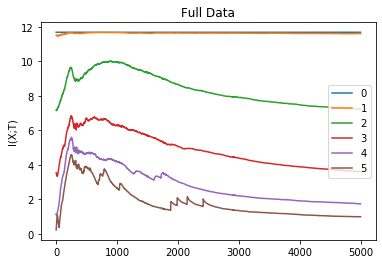

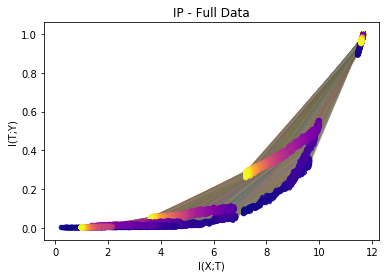

In [30]:
plot_info_plan(MI_XH, MI_YH)